[ 16 113  94 228  85 158 131   4 127 236]
(300,)
2


0.32000000000000001

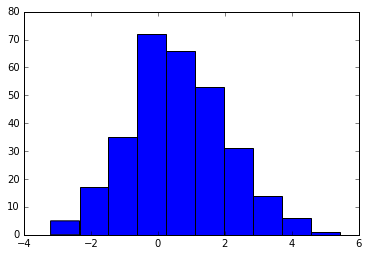

In [1]:
"""
Some experiments involving SGLD, though I'm not sure how much we'll be using of this, if any.
"""

# Import a few obvious things.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#####################
## LET US BEGIN !! ##
#####################

# Generate the data according to Section 5.1 of the "Bayesian Learning via SGLD" (2011) paper.
sigma1_sq = 10
sigma2_sq = 1
sigmax_sq = 2
theta1 = 0
theta2 = 1
N = 300

# Generate the data matrix. Note that the np.random.normal(...) requires STD (not VAR) as input.
X = np.zeros(N)
for i in xrange(N):
    u = np.random.random()
    if (u < 0.5):
        X[i] = np.random.normal(theta1, np.sqrt(sigmax_sq))
    else:
        X[i] = np.random.normal(theta1+theta2, np.sqrt(sigmax_sq))

# Visualize the data (not what we want to do but good for extra understanding).
plt.figure()
plt.hist(X, bins=10)

# Note: how do we know the posterior distribution of \theta?

# Well I can worry about that later. Here's some stuff I'll need for later.
# EDIT: I think we definitely want replace = False.
print np.random.choice(len(X),10,replace=False)
print X.shape
print len(X[np.random.choice(len(X),2)])

# Load some of Haoyu's stuff in advance.
import scipy.io
from bisect import bisect
mat = scipy.io.loadmat('ecdf.mat')
x_l = mat['x_l'][0]
x_corr = mat['x_corr'][0]
ecdf_l = mat['ecdf_l'][0]
ecdf_corr = mat['ecdf_corr'][0]
bisect(x_l, 0.31)
x_l[1032]

In [2]:
# Get all the necessary functions defined.

def f(theta, X, N, scale=True):
    """
    First, let's define the function 'f' that we're trying to optimize via gradient methods.
    We'll compute gradients by finite differences. But we also need the X information.
    Note: best to think of this as f(theta;X,N) since X is assumed given and isn't a variable.
    Also, N is the total number of samples, not the same as the number in X (generally) since
    X should usually be a mini-batch. If we DO NOT want that, set scale=False.
    """
    cov_inv = np.array([[0.1,0],[0,1]])
    c1 = np.log(1.0/(2*np.pi*np.sqrt(10)))
    c2 = np.log(1.0/(4*np.sqrt(np.pi)))
    
    # Compute the two terms we need for the function using the two constants from earlier.
    first = c1 - 0.5*(theta.T).dot(cov_inv).dot(theta)
    second = 0
    
    # The 'frac' is the N/n term that rescales gradients to be the same size.
    frac = float(N)/len(X)
    assert len(X) <= N
    for x_i in X:
        second += c2 + np.log(np.exp(-0.25*(x_i - theta[0])**2) + np.exp(-0.25*(x_i - (theta[0]+theta[1]))**2))
    return (first + frac*second)[0,0] # Odd quirk, this returns a scalar.


def grad_f(theta, X, N, scale=True):
    """ Computes gradient of f by finite differences. X is (usually) a mini-batch. """
    eps = 0.00001
    base1 = np.array([[eps],[0]])
    base2 = np.array([[0],[eps]])
    term1 = f(theta+base1, X, N, scale) - f(theta-base1, X, N, scale)
    term2 = f(theta+base2, X, N, scale) - f(theta-base2, X, N, scale)
    return np.array([[term1],[term2]])/(2*eps)


def get_noise(eps):
    """ Put this here because of a lot of text and we have to reshape at the end. """
    return (np.random.multivariate_normal(np.array([0,0]), eps*np.eye(2))).reshape((2,1))


def get_delta(theta_0, theta_1, eps, X, N, scale=True, rand_walk=False):
    """
    Compute the delta which is used to do the test 
    Note: the 'p_{old,new}_theta' stuff uses log(pdfnorm(...)) but the 1/sqrt{2pi sigma^2} 
    term disappears, and the exponentials cancel, which is why we get what we have now.
    Similarly, in high dimensions, the covariance matrix inverse has a bunch of 1/eps terms.
    It's also true that this should be eps here, NOT eps^2.
    If rand_walk = True, then we do not need to compute p_old_new and p_new_old b/c symmetric.
    """
    loss_old = f(theta_0, X, N, scale)
    loss_new = f(theta_1, X, N, scale)
    if rand_walk:
        gradient = grad_f(theta_0, X, N, scale)
        diff_theta = theta_1 - (theta_0 + (eps/2.0)*gradient)
        p_old_new = -1.0/2.0 / eps * np.sum(diff_theta**2)
        gradient = grad_f(theta_1, X, N, scale)
        diff_theta = theta_0 - (theta_1 + (eps/2.0)*gradient)
        p_new_old = -1.0/2.0/eps * np.sum(diff_theta**2)    
        return loss_new - loss_old + p_new_old - p_old_new
    else:
        return loss_new - loss_old

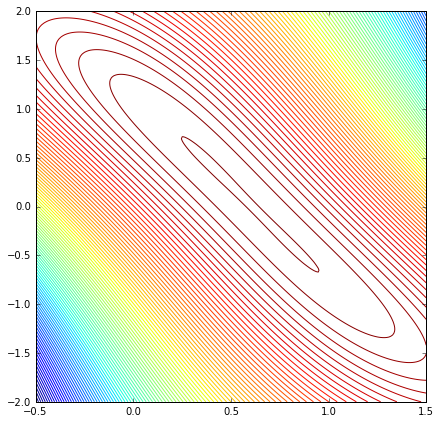

In [5]:
""" 
Let's try a contour plot just to make sure the posterior makes sense ...
UPDATE: Yes, I should be right! But this figure can take about a minute to generate.
"""

K=200 # Carefull ... this will make it long!
xlist = np.linspace(-0.5, 1.5, num=K)
ylist = np.linspace(-3.0, 3.0, num=K)
X_a,Y_a = np.meshgrid(xlist, ylist)
Z_a = np.zeros((K,K))
for i in range(K):
    for j in range(K):
        theta = np.array( [[X_a[i,j]],[Y_a[i,j]]] )
        Z_a[i,j] = f(theta, X, N)
        
plt.figure(figsize=(7,7))
plt.contour(X_a,Y_a,Z_a,100)

In [48]:
""" One idea: run all six of these _together_ so I don't keep fumbling up my settings. """

# Some parameters, The num_passes and mb_size are most important; a and b only for SGLD.
num_passes = 8000
mb_size = 5
a = 0.06
b = 30
sd = 0
print("f([0,1]) = {}, N = {}".format(f(np.array([[0],[1]]), X, N), N))

# Important, we have *six* different \thetas to keep track of.
theta_1 = np.array([[0], [1]])
theta_2 = np.array([[0], [1]])
theta_3 = np.array([[0], [1]])
theta_4 = np.array([[0], [1]])
theta_5 = np.array([[0], [1]])
theta_6 = np.array([[0], [1]])

# This will help us store our thetas.
all_1 = theta_1
all_2 = theta_2
all_3 = theta_3
all_4 = theta_4
all_5 = theta_5
all_6 = theta_6

# Keep track of rejections
rej_3 = []
rej_4 = []
rej_5 = []
rej_6 = []

# One "pass" means one "minibatch" in which we evaluate a gradient.
for t in range(1,num_passes):

    # We can have two different step sizes, corresponding to to SGLD's way, and *our* way.
    eps_v1 = a*((b + t) ** (-0.55))
    eps_v2 = 0.002
    
    # Just for debugging.
    if (t % int(num_passes/20) == 0 or t == 1):
        print("pass={}, eps_v1={:.5f}, eps_v2={:.5f}".format(t, eps_v1, eps_v2))

    # Choose a minibatch without replacement.
    X_mini_1 = X[np.random.choice(N, mb_size, replace=False)]
    X_mini_2 = X[np.random.choice(N, mb_size, replace=False)]
    X_mini_3 = X[np.random.choice(N, mb_size, replace=False)]
    X_mini_4 = X[np.random.choice(N, mb_size, replace=False)]
    X_mini_5 = X[np.random.choice(N, mb_size, replace=False)]
    X_mini_6 = X[np.random.choice(N, mb_size, replace=False)]
    
    # Compute the corresponding gradient terms; *all six* use a minibatch.
    gradient_1 = grad_f(theta_1, X_mini_1, N, scale=True)
    gradient_2 = grad_f(theta_2, X_mini_2, N, scale=True)
    gradient_3 = grad_f(theta_3, X_mini_3, N, scale=True)
    gradient_4 = grad_f(theta_4, X_mini_4, N, scale=True)
    gradient_5 = grad_f(theta_5, X_mini_5, N, scale=True)
    gradient_6 = grad_f(theta_6, X_mini_6, N, scale=True)
    
    # Compute the corresponding theta updates. Careful, eps_v2 is applied to all but the first.
    theta_1     = theta_1 + (eps_v1/2.0)*gradient_1 + get_noise(eps_v1)
    theta_2     = theta_2 + (eps_v2/2.0)*gradient_2 + get_noise(eps_v2)
    theta_3_new = theta_3 + (eps_v2/2.0)*gradient_3 + get_noise(eps_v2)
    theta_4_new = theta_4 + (eps_v2/2.0)*gradient_4 + get_noise(eps_v2)
    theta_5_new = theta_5 + (eps_v2/2.0)*gradient_5 + get_noise(eps_v2)
    theta_6_new = theta_6 + (eps_v2/2.0)*gradient_6 + get_noise(eps_v2)
    
    # Just be a little careful ...
    assert not np.isnan(np.sum(theta_1))
    assert not np.isnan(np.sum(theta_2))
    assert not np.isnan(np.sum(theta_3))
    assert not np.isnan(np.sum(theta_4))
    assert not np.isnan(np.sum(theta_5))
    assert not np.isnan(np.sum(theta_6))

    # For Tests 1 and 2, no MH test or additional work is needed.
    all_1 = np.concatenate((all_1,theta_1), axis=1)
    all_2 = np.concatenate((all_2,theta_2), axis=1)
    
    # For Tests 3 and 5, we compute \Delta (for MH test) based on the full data.
    delta_3 = get_delta(theta_3, theta_3_new, eps_v2, X, N, scale=True)
    delta_5 = get_delta(theta_5, theta_5_new, eps_v2, X, N, scale=True)
    
    # For Tests 4 and 6, we compute \Delta (for MH test) based on a new random minibatch.
    X_mb_4 = X[np.random.choice(N, mb_size, replace=False)]
    X_mb_6 = X[np.random.choice(N, mb_size, replace=False)]
    delta_4 = get_delta(theta_4, theta_4_new, eps_v2, X_mb_4, N, scale=True)
    delta_6 = get_delta(theta_6, theta_6_new, eps_v2, X_mb_6, N, scale=True)
    
    # For Tests 3 and 4, we use the standard MH test.
    pa_3 = np.min([1, np.exp(delta_3)])
    pa_4 = np.min([1, np.exp(delta_4)])
    u_3 = np.random.random()
    u_4 = np.random.random()
    if (u_3 < pa_3):
        theta_3 = theta_3_new
        all_3 = np.concatenate((all_3,theta_3), axis=1)
    else:
        rej_3.append(t)
    if (u_4 < pa_4):
        theta_4 = theta_4_new
        all_4 = np.concatenate((all_4,theta_4), axis=1)
    else:
        rej_4.append(t)
        
    # For Test 5, we use our new MH test, and estimate from the logistic (no noise):
    u_5 = np.random.random()
    X_log_5 = ecdf_l[bisect(x_l, u_5)]
    if (X_log_5 + delta_5 > 0):
        theta_5 = theta_5_new
        all_5 = np.concatenate((all_5,theta_5), axis=1)
    else:
        rej_5.append(t)
        
    # Finally, for Test 6, we also use the MH test, but we *also* need to estimate the variance!
    # Do this two more times to make it three total (just to make it easy).
    X_mini_6_1 = X[np.random.choice(N, mb_size, replace=False)]
    X_mini_6_2 = X[np.random.choice(N, mb_size, replace=False)]
    gradient_6_1 = grad_f(theta_6, X_mini_6_1, N, scale=True)
    gradient_6_2 = grad_f(theta_6, X_mini_6_2, N, scale=True)
    theta_6_1 = theta_6 + (eps_v2/2.0)*gradient_6_1 + get_noise(eps_v2)
    theta_6_2 = theta_6 + (eps_v2/2.0)*gradient_6_2 + get_noise(eps_v2)
    delta_6_1 = get_delta(theta_6, theta_6_1, eps_v2, X_mini_6_1, N, scale=True)
    delta_6_2 = get_delta(theta_6, theta_6_2, eps_v2, X_mini_6_1, N, scale=True)
    
    # I still don't get why we do this, but let's try it for now.
    X_mini_6_real = X[np.random.choice(N, mb_size, replace=False)]
    delta_6_real = get_delta(theta_6, theta_6_new, eps_v2, X_mini_6_1, N, scale=True)
    
    # Moving average update of the standard deviation. Do not use the one depending on delta_6.
    sd = 0.7*sd + 0.3*np.std([delta_6, delta_6_1, delta_6_2])
    u_6 = np.random.random()
    X_log = ecdf_l[bisect(x_l, u_6)]
    X_corr = ecdf_corr[bisect(x_corr, u_6)]
    X_corr = X_corr * sd
    
    # Now *finally* do the test!
    if (X_corr_6 + delta_6_real > 0):
        theta_6 = theta_6_new
        all_6 = np.concatenate((all_6,theta_6), axis=1)
    else:
        rej_6.append(t)

print("\nAll done!")

f([0,1]) = -558.021746519, N = 300
pass=1, eps_v1=0.00908, eps_v2=0.00200
pass=400, eps_v1=0.00214, eps_v2=0.00200
pass=800, eps_v1=0.00149, eps_v2=0.00200
pass=1200, eps_v1=0.00120, eps_v2=0.00200
pass=1600, eps_v1=0.00103, eps_v2=0.00200
pass=2000, eps_v1=0.00091, eps_v2=0.00200
pass=2400, eps_v1=0.00082, eps_v2=0.00200
pass=2800, eps_v1=0.00076, eps_v2=0.00200
pass=3200, eps_v1=0.00070, eps_v2=0.00200
pass=3600, eps_v1=0.00066, eps_v2=0.00200
pass=4000, eps_v1=0.00062, eps_v2=0.00200
pass=4400, eps_v1=0.00059, eps_v2=0.00200
pass=4800, eps_v1=0.00056, eps_v2=0.00200
pass=5200, eps_v1=0.00054, eps_v2=0.00200
pass=5600, eps_v1=0.00052, eps_v2=0.00200
pass=6000, eps_v1=0.00050, eps_v2=0.00200
pass=6400, eps_v1=0.00048, eps_v2=0.00200
pass=6800, eps_v1=0.00047, eps_v2=0.00200
pass=7200, eps_v1=0.00045, eps_v2=0.00200
pass=7600, eps_v1=0.00044, eps_v2=0.00200

All done!


(2, 8000)
(2, 8000)
(2, 4946)
(2, 4494)
(2, 4483)
(2, 4448)


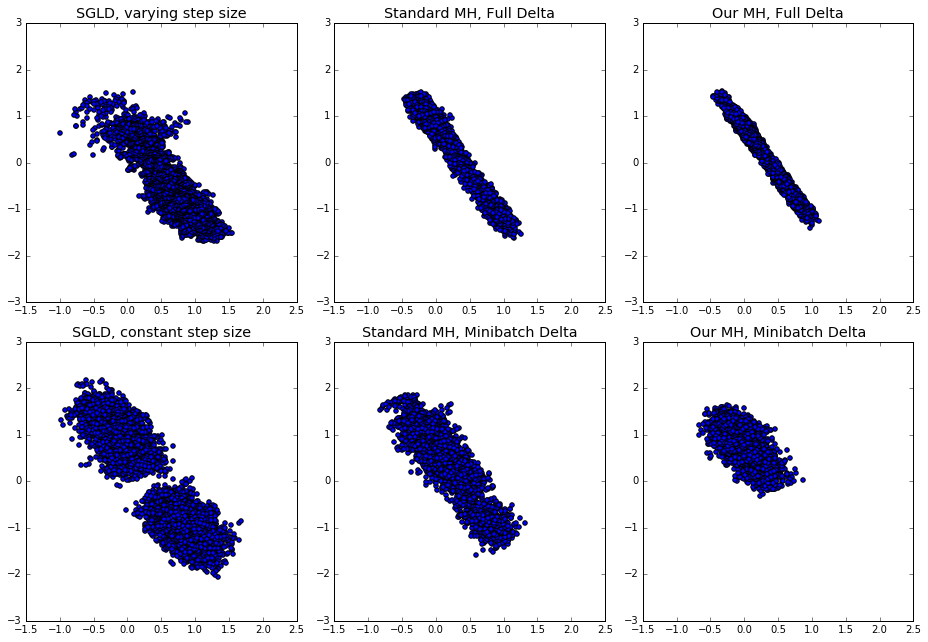

In [49]:
""" Now plot the results! Can also deal with other statistics, such as the rejections, etc. """

print(all_1.shape)
print(all_2.shape)
print(all_3.shape)
print(all_4.shape)
print(all_5.shape)
print(all_6.shape)

fig, axarr = plt.subplots(2,3, figsize=(13, 9))

axarr[0,0].set_title("SGLD, varying step size", size="x-large")
axarr[0,0].scatter(all_1[0], all_1[1])
axarr[0,0].set_xlim([-1.5,2.5])
axarr[0,0].set_ylim([-3,3])

axarr[1,0].set_title("SGLD, constant step size", size="x-large")
axarr[1,0].scatter(all_2[0], all_2[1])
axarr[1,0].set_xlim([-1.5,2.5])
axarr[1,0].set_ylim([-3,3])

axarr[0,1].set_title("Standard MH, Full Delta", size="x-large")
axarr[0,1].scatter(all_3[0], all_3[1])
axarr[0,1].set_xlim([-1.5,2.5])
axarr[0,1].set_ylim([-3,3])

axarr[1,1].set_title("Standard MH, Minibatch Delta", size="x-large")
axarr[1,1].scatter(all_4[0], all_4[1])
axarr[1,1].set_xlim([-1.5,2.5])
axarr[1,1].set_ylim([-3,3])

axarr[0,2].set_title("Our MH, Full Delta", size="x-large")
axarr[0,2].scatter(all_5[0], all_5[1])
axarr[0,2].set_xlim([-1.5,2.5])
axarr[0,2].set_ylim([-3,3])

axarr[1,2].set_title("Our MH, Minibatch Delta", size="x-large")
axarr[1,2].scatter(all_6[0], all_6[1])
axarr[1,2].set_xlim([-1.5,2.5])
axarr[1,2].set_ylim([-3,3])

plt.tight_layout()

In [50]:
"""
Let's do something similar, except with random walk proposals.
"""

# Some parameters, The num_passes and mb_size are most important; a and b only for SGLD.
num_passes = 8000
mb_size = 5
a = 0.06
b = 30
sd = 0
print("f([0,1]) = {}, N = {}".format(f(np.array([[0],[1]]), X, N), N))

# Important, we have *six* different \thetas to keep track of.
theta_1 = np.array([[0], [1]])
theta_2 = np.array([[0], [1]])
theta_3 = np.array([[0], [1]])
theta_4 = np.array([[0], [1]])
theta_5 = np.array([[0], [1]])
theta_6 = np.array([[0], [1]])

# This will help us store our thetas.
all_1 = theta_1
all_2 = theta_2
all_3 = theta_3
all_4 = theta_4
all_5 = theta_5
all_6 = theta_6

# Keep track of rejections
rej_3 = []
rej_4 = []
rej_5 = []
rej_6 = []

# One "pass" means one "minibatch" in which we evaluate a gradient.
for t in range(1,num_passes):

    # We can have two different step sizes, corresponding to to SGLD's way, and *our* way.
    eps_v1 = a*((b + t) ** (-0.55))
    eps_v2 = 0.002
    
    # Just for debugging.
    if (t % int(num_passes/20) == 0 or t == 1):
        print("pass={}, eps_v1={:.5f}, eps_v2={:.5f}".format(t, eps_v1, eps_v2))

    # Choose a minibatch without replacement.
    X_mini_1 = X[np.random.choice(N, mb_size, replace=False)]
    X_mini_2 = X[np.random.choice(N, mb_size, replace=False)]
    X_mini_3 = X[np.random.choice(N, mb_size, replace=False)]
    X_mini_4 = X[np.random.choice(N, mb_size, replace=False)]
    X_mini_5 = X[np.random.choice(N, mb_size, replace=False)]
    X_mini_6 = X[np.random.choice(N, mb_size, replace=False)]
    
    # Compute the theta updates using random walks.
    theta_1     = theta_1 + get_noise(0.3)
    theta_2     = theta_2 + get_noise(0.3)
    theta_3_new = theta_3 + get_noise(0.3)
    theta_4_new = theta_4 + get_noise(0.3)
    theta_5_new = theta_5 + get_noise(0.3)
    theta_6_new = theta_6 + get_noise(0.3)
    
    # Just be a little careful ...
    assert not np.isnan(np.sum(theta_1))
    assert not np.isnan(np.sum(theta_2))
    assert not np.isnan(np.sum(theta_3))
    assert not np.isnan(np.sum(theta_4))
    assert not np.isnan(np.sum(theta_5))
    assert not np.isnan(np.sum(theta_6))

    # For Tests 1 and 2, no MH test or additional work is needed. EDIT: Well this should fail spectacularly.
    all_1 = np.concatenate((all_1,theta_1), axis=1)
    all_2 = np.concatenate((all_2,theta_2), axis=1)
    
    # For Tests 3 and 5, we compute \Delta (for MH test) based on the full data.
    delta_3 = get_delta(theta_3, theta_3_new, eps_v2, X, N, scale=True, rand_walk=True)
    delta_5 = get_delta(theta_5, theta_5_new, eps_v2, X, N, scale=True, rand_walk=True)
    
    # For Tests 4 and 6, we compute \Delta (for MH test) based on a new random minibatch.
    X_mb_4 = X[np.random.choice(N, mb_size, replace=False)]
    X_mb_6 = X[np.random.choice(N, mb_size, replace=False)]
    delta_4 = get_delta(theta_4, theta_4_new, eps_v2, X_mb_4, N, scale=True, rand_walk=True)
    delta_6 = get_delta(theta_6, theta_6_new, eps_v2, X_mb_6, N, scale=True, rand_walk=True)
    
    # For Tests 3 and 4, we use the standard MH test.
    pa_3 = np.min([1, np.exp(delta_3)])
    pa_4 = np.min([1, np.exp(delta_4)])
    u_3 = np.random.random()
    u_4 = np.random.random()
    if (u_3 < pa_3):
        theta_3 = theta_3_new
        all_3 = np.concatenate((all_3,theta_3), axis=1)
    else:
        rej_3.append(t)
    if (u_4 < pa_4):
        theta_4 = theta_4_new
        all_4 = np.concatenate((all_4,theta_4), axis=1)
    else:
        rej_4.append(t)
        
    # For Test 5, we use our new MH test, and estimate from the logistic (no noise):
    u_5 = np.random.random()
    X_log_5 = ecdf_l[bisect(x_l, u_5)]
    if (X_log_5 + delta_5 > 0):
        theta_5 = theta_5_new
        all_5 = np.concatenate((all_5,theta_5), axis=1)
    else:
        rej_5.append(t)
        
    # Finally, for Test 6, we also use the MH test, but we *also* need to estimate the variance!
    # Do this two more times to make it three total (just to make it easy).
    X_mini_6_1 = X[np.random.choice(N, mb_size, replace=False)]
    X_mini_6_2 = X[np.random.choice(N, mb_size, replace=False)]
    theta_6_1 = theta_6 + get_noise(0.3)
    theta_6_2 = theta_6 + get_noise(0.3)
    delta_6_1 = get_delta(theta_6, theta_6_1, eps_v2, X_mini_6_1, N, scale=True, rand_walk=True)
    delta_6_2 = get_delta(theta_6, theta_6_2, eps_v2, X_mini_6_1, N, scale=True, rand_walk=True)
    
    # I still don't get why we do this, but let's try it for now.
    X_mini_6_real = X[np.random.choice(N, mb_size, replace=False)]
    delta_6_real = get_delta(theta_6, theta_6_new, eps_v2, X_mini_6_1, N, scale=True, rand_walk=True)
    
    # Moving average update of the standard deviation. Do not use the one depending on delta_6.
    sd = 0.7*sd + 0.3*np.std([delta_6, delta_6_1, delta_6_2])
    u_6 = np.random.random()
    X_log = ecdf_l[bisect(x_l, u_6)]
    X_corr = ecdf_corr[bisect(x_corr, u_6)]
    X_corr = X_corr * sd
    
    # Now *finally* do the test!
    if (X_corr_6 + delta_6_real > 0):
        theta_6 = theta_6_new
        all_6 = np.concatenate((all_6,theta_6), axis=1)
    else:
        rej_6.append(t)

print("\nAll done!")

f([0,1]) = -558.021746519, N = 300
pass=1, eps_v1=0.00908, eps_v2=0.00200
pass=400, eps_v1=0.00214, eps_v2=0.00200
pass=800, eps_v1=0.00149, eps_v2=0.00200
pass=1200, eps_v1=0.00120, eps_v2=0.00200
pass=1600, eps_v1=0.00103, eps_v2=0.00200
pass=2000, eps_v1=0.00091, eps_v2=0.00200
pass=2400, eps_v1=0.00082, eps_v2=0.00200
pass=2800, eps_v1=0.00076, eps_v2=0.00200
pass=3200, eps_v1=0.00070, eps_v2=0.00200
pass=3600, eps_v1=0.00066, eps_v2=0.00200
pass=4000, eps_v1=0.00062, eps_v2=0.00200
pass=4400, eps_v1=0.00059, eps_v2=0.00200
pass=4800, eps_v1=0.00056, eps_v2=0.00200
pass=5200, eps_v1=0.00054, eps_v2=0.00200
pass=5600, eps_v1=0.00052, eps_v2=0.00200
pass=6000, eps_v1=0.00050, eps_v2=0.00200
pass=6400, eps_v1=0.00048, eps_v2=0.00200
pass=6800, eps_v1=0.00047, eps_v2=0.00200
pass=7200, eps_v1=0.00045, eps_v2=0.00200
pass=7600, eps_v1=0.00044, eps_v2=0.00200

All done!


(2, 8000)
(2, 8000)
(2, 2917)
(2, 4067)
(2, 2232)
(2, 3523)


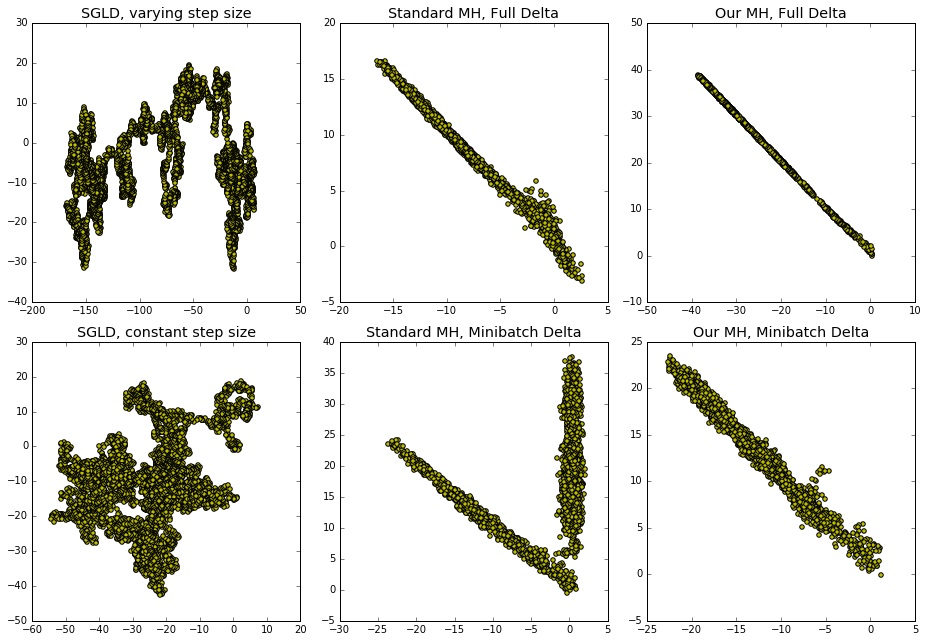

In [53]:
""" Now plot the results! Can also deal with other statistics, such as the rejections, etc. """

print(all_1.shape)
print(all_2.shape)
print(all_3.shape)
print(all_4.shape)
print(all_5.shape)
print(all_6.shape)

fig, axarr = plt.subplots(2,3, figsize=(13, 9))

axarr[0,0].set_title("SGLD, varying step size", size="x-large")
axarr[0,0].scatter(all_1[0], all_1[1], c='y')
#axarr[0,0].set_xlim([-1.5,2.5])
#axarr[0,0].set_ylim([-3,3])

axarr[1,0].set_title("SGLD, constant step size", size="x-large")
axarr[1,0].scatter(all_2[0], all_2[1], c='y')
#axarr[1,0].set_xlim([-1.5,2.5])
#axarr[1,0].set_ylim([-3,3])

axarr[0,1].set_title("Standard MH, Full Delta", size="x-large")
axarr[0,1].scatter(all_3[0], all_3[1], c='y')
#axarr[0,1].set_xlim([-1.5,2.5])
#axarr[0,1].set_ylim([-3,3])

axarr[1,1].set_title("Standard MH, Minibatch Delta", size="x-large")
axarr[1,1].scatter(all_4[0], all_4[1], c='y')
#axarr[1,1].set_xlim([-1.5,2.5])
#axarr[1,1].set_ylim([-3,3])

axarr[0,2].set_title("Our MH, Full Delta", size="x-large")
axarr[0,2].scatter(all_5[0], all_5[1], c='y')
#axarr[0,2].set_xlim([-1.5,2.5])
#axarr[0,2].set_ylim([-3,3])

axarr[1,2].set_title("Our MH, Minibatch Delta", size="x-large")
axarr[1,2].scatter(all_6[0], all_6[1], c='y')
#axarr[1,2].set_xlim([-1.5,2.5])
#axarr[1,2].set_ylim([-3,3])

plt.tight_layout()

In [ ]:
## UPDATE (May 11, 2016): Don't use the following for now.

In [3]:
"""
Test matrix #1: standard SGLD, with decreasing step size that they employ.
"""
num_passes = 20000
a = 0.1
b = 0.1
theta = np.array([[0], [1]])
all_thetas_1 = theta
print("f([0,1]) = {}, N = {}".format(f(np.array([[0],[1]]), X, N), N))
mb_size = 5

# A bit unclear what they mean by "10k sweeps" over the data, but I think for each iteration,
# of which I have 10k, I will iterate through each *element* one by one.
for t in range(1,num_passes):
    eps = a*((b + t) ** (-0.55))
    
    # Just for debugging.
    if (t % int(num_passes/10) == 0 or t == 1):
        print("pass={}".format(t))
        print("\teps={:.5f}, theta.t={}".format(eps, theta.T))
    
    # The following section is how the paper did it (I think), but we would need to iterate sequentially.
    # Now iterate through each element. This does mean step-size is constant, though.
    """
    for (i,x_i) in enumerate(X):
        X_mini = np.array([x_i])
        gradient = grad_f(theta, X_mini, N, scale=True)
        theta = theta + (eps/2.0)*gradient + get_noise(eps) 
        all_thetas = np.concatenate((all_thetas,theta), axis=1)
    """
    
    # Alternative: choose mb_size element at random, and then do gradient. Requires more iterations.
    X_mini = X[np.random.choice(N, mb_size, replace=False)]
    gradient = grad_f(theta, X_mini, N, scale=True)
    theta = theta + (eps/2.0)*gradient + get_noise(eps)
    all_thetas = np.concatenate((all_thetas,theta), axis=1) 

print("Done! all_thetas_1.shape = {}".format(all_thetas_1.shape))

f([0,1]) = -185.358649894, N = 100
pass=1
	eps=0.09489, theta.t=[[0 1]]
pass=2000
	eps=0.00153, theta.t=[[-0.05437272  1.31560156]]
pass=4000
	eps=0.00104, theta.t=[[ 0.20312182  0.51318465]]
pass=6000
	eps=0.00084, theta.t=[[ 0.42646408  0.6223556 ]]
pass=8000
	eps=0.00071, theta.t=[[ 0.0237536   0.80088494]]
pass=10000
	eps=0.00063, theta.t=[[ 0.12499385  0.90200061]]
pass=12000
	eps=0.00057, theta.t=[[ 0.51773806 -0.2603679 ]]
pass=14000
	eps=0.00052, theta.t=[[ 1.24116231 -1.45431957]]
pass=16000
	eps=0.00049, theta.t=[[ 1.31672525 -1.67804699]]
pass=18000
	eps=0.00046, theta.t=[[ 0.58814835 -0.12883044]]
Done! all_thetas.shape = (2, 20000)


(20000,)


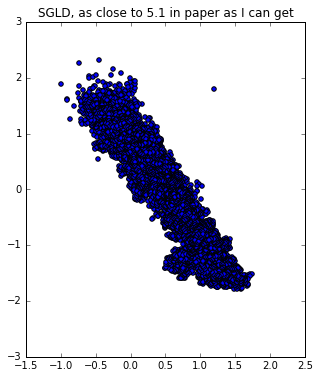

In [4]:
print(all_1.shape)
plt.figure(figsize=(5,6))
plt.scatter(all_thetas[0], all_thetas[1])
plt.xlim([-1.5,2.5])
plt.ylim([-3,3])
plt.title("SGLD, as close to 5.1 in paper as I can get")

In [5]:
"""
Test #1: gradient computed w/minibatch, \Delta computed w/full data, and MH test is the standard test.
"""
num_passes = 20000
a = 0.1
b = 0.1
theta = np.array([[0], [1]])
all_thetas = theta
print("f([0,1]) = {}, N = {}".format(f(np.array([[0],[1]]), X, N), N))
mb_size = 10

for t in range(1,num_passes):
    eps = a*((b + t) ** (-0.55))
    
    # Just for debugging.
    if (t % int(num_passes/10) == 0 or t == 1):
        print("pass={}".format(t))
        print("\teps={:.5f}, theta.t={}".format(eps, theta.T))
    
    # Extract mini-batch at random (w/out replacement) and compute gradient w/that.
    X_mini = X[np.random.choice(N, mb_size, replace=False)]
    gradient = grad_f(theta, X_mini, N, scale=True)
    theta1 = theta + (eps/2.0)*gradient + get_noise(eps) 
    
    # Compute delta based on the full data.
    delta_full = get_delta(theta, theta1, eps, X, N, scale=True)
    pa = np.min([1, np.exp(delta_full)])

    u = np.random.random()
    if (u < pa):
        theta = theta1
        all_thetas = np.concatenate((all_thetas,theta), axis=1)
        
print("Done! all_thetas.shape = {}".format(all_thetas.shape))

f([0,1]) = -185.358649894, N = 100
pass=1
	eps=0.09489, theta.t=[[0 1]]
pass=2000
	eps=0.00153, theta.t=[[ 0.05808619  1.0257656 ]]
pass=4000
	eps=0.00104, theta.t=[[ 0.63646312 -0.14311727]]
pass=6000
	eps=0.00084, theta.t=[[ 0.72362175 -0.70074659]]
pass=8000
	eps=0.00071, theta.t=[[ 0.54888577 -0.43794499]]
pass=10000
	eps=0.00063, theta.t=[[-0.22998539  0.83221909]]
pass=12000
	eps=0.00057, theta.t=[[ 0.52384355  0.01218298]]
pass=14000
	eps=0.00052, theta.t=[[-0.22727572  1.31238493]]
pass=16000
	eps=0.00049, theta.t=[[-0.32246329  1.61774977]]
pass=18000
	eps=0.00046, theta.t=[[ 0.14369098  1.24697247]]
Done! all_thetas.shape = (2, 19955)


(19955,)


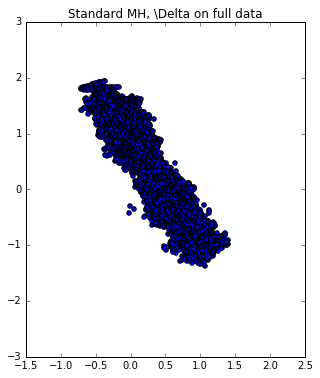

In [6]:
# Scatter plot of all_thetas.
print all_thetas[0].shape
plt.figure(figsize=(5,6))
plt.scatter(all_thetas[0], all_thetas[1])
plt.xlim([-1.5,2.5])
plt.ylim([-3,3])
plt.title("Standard MH, \Delta on full data")

In [11]:
"""
Test #2: gradient computed w/minibatch, \Delta computed w/minibatch, and MH test is the standard test.
"""
num_passes = 20000
a = 0.1
b = 0.1
theta = np.array([[0], [1]])
all_thetas = theta
print("f([0,1]) = {}, N = {}".format(f(np.array([[0],[1]]), X, N), N))
mb_size = 10

for t in range(1,num_passes):
    eps = a*((b + t) ** (-0.55))
    
    # Just for debugging
    if (t % int(num_passes/10) == 0 or t == 1):
        print("pass={}".format(t))
        print("\teps={:.5f}, theta.t={}".format(eps, theta.T))

    # Extract mini-batch at random (w/out replacement) and compute gradient w/that.
    X_mini = X[np.random.choice(N, mb_size, replace=False)]
    gradient = grad_f(theta, X_mini, N, scale=True)
    theta1 = theta + (eps/2.0)*gradient + get_noise(eps) 
    
    # Compute approximation of \Delta based on a mini-batch of that.
    X_mb_new = X[np.random.choice(N, mb_size, replace=False)]
    delta_small = get_delta(theta, theta1, eps, X_mb_new, N, scale=True)
    pa = np.min([1, np.exp(delta_small)])
    
    u = np.random.random()
    if (u < pa):
        theta = theta1
        all_thetas = np.concatenate((all_thetas,theta), axis=1)
    
print("Done! all_thetas.shape = {}".format(all_thetas.shape))

f([0,1]) = -185.358649894, N = 100
pass=1
	eps=0.09489, theta.t=[[0 1]]
pass=2000
	eps=0.00153, theta.t=[[ 0.44490278  0.33818797]]
pass=4000
	eps=0.00104, theta.t=[[ 0.30144156  0.30233429]]
pass=6000
	eps=0.00084, theta.t=[[-0.2066011   1.18865672]]
pass=8000
	eps=0.00071, theta.t=[[-0.06724843  0.58334265]]
pass=10000
	eps=0.00063, theta.t=[[ 0.05836752  0.89904634]]
pass=12000
	eps=0.00057, theta.t=[[ 0.05801953  0.88096044]]
pass=14000
	eps=0.00052, theta.t=[[ 0.26359054  0.6290986 ]]
pass=16000
	eps=0.00049, theta.t=[[-0.45286681  1.38066087]]
pass=18000
	eps=0.00046, theta.t=[[-0.00276008  1.18126031]]
Done! all_thetas.shape = (2, 19899)


(19899,)


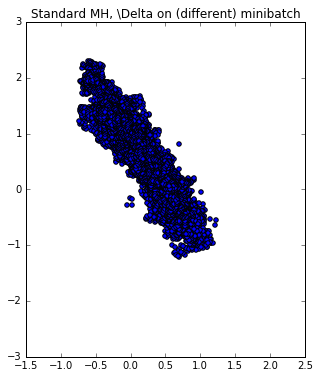

In [12]:
print all_thetas[0].shape
plt.figure(figsize=(5,6))
plt.scatter(all_thetas[0], all_thetas[1])
plt.xlim([-1.5,2.5])
plt.ylim([-3,3])
plt.title("Standard MH, \Delta on (different) minibatch")

In [4]:
"""
Test #3: gradient with mini-batch, \Delta on the full data, but with *our* MH-test.
"""
num_passes = 20000
a = 0.1
b = 0.1
theta = np.array([[0], [1]])
all_thetas = theta
print("f([0,1]) = {}, N = {}".format(f(np.array([[0],[1]]), X, N), N))
mb_size = 10

for t in range(1,num_passes):
    eps = a*((b + t) ** (-0.55))
    
    # Just for debugging
    if (t % int(num_passes/10) == 0 or t == 1):
        print("pass={}".format(t))
        print("\teps={:.5f}, theta.t={}".format(eps, theta.T))

    # Extract mini-batch at random (w/out replacement) and compute gradient w/that.
    X_mini = X[np.random.choice(N, mb_size, replace=False)]
    gradient = grad_f(theta, X_mini, N, scale=True)
    theta1 = theta + (eps/2.0)*gradient + get_noise(eps) 
    
    # Compute Delta based on the full data, and use our MH test.
    delta_full = get_delta(theta, theta1, eps, X, N, scale=True)
    u = np.random.random()
    X_log = ecdf_l[bisect(x_l, u)]
    X_corr = ecdf_corr[bisect(x_corr, u)]
    
    if (X_log + delta_full > 0):
        theta = theta1
        all_thetas = np.concatenate((all_thetas,theta), axis=1)

print("Done! all_thetas.shape = {}".format(all_thetas.shape))

f([0,1]) = -528.134336158, N = 300
pass=1
	eps=0.09489, theta.t=[[0 1]]


KeyboardInterrupt: 

(19984,)


(-3, 3)

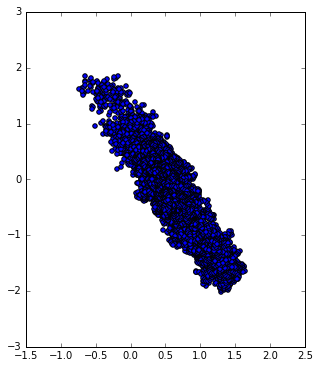

In [10]:
print all_thetas[0].shape
plt.figure(figsize=(5,6))
plt.scatter(all_thetas[0], all_thetas[1])
plt.xlim([-1.5,2.5])
plt.ylim([-3,3])